# COSC_4117EL_A1_G2

## Objective
- Develop a Python program to solve a binary puzzle using multiple constraint satisfaction algorithms.
- Evaluate the performance of each algorithm based on different puzzle sizes.

## Constraints
1. Each cell must contain a number either 0 or 1.
2. No three consecutive ones or zeros in a row or a column.
3. The number of ones and zeros in each row and each column is the same.
4. No two rows or two columns can be identical.


In [2]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
from collections import defaultdict
import json
from func_timeout import func_set_timeout, FunctionTimedOut
import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

## Part 1: Reading the Puzzle and Print the Solution

In [2]:
def read_puzzle(file_name):
    with open(file_name, 'r') as f:
        puzzle = [list(line.strip()) for line in f.readlines()]
    return puzzle

def print_solution(puzzle):
    for row in puzzle:
        print(''.join(row))

## Part 2: Solving the Puzzle as a CSP

In [3]:
def neighbors(puzzle, row, col, n):
    """Define neighbors for each cell"""
    return [(row, j) for j in range(n) if j != col and puzzle[row][j] == '_'] + \
            [(i, col) for i in range(n) if i != row and puzzle[i][col] == '_']

def is_valid(puzzle, row, col, n, num):
    """Check if placing num at puzzle[row][col] is valid."""
    # Directly place the number and store the old value for reverting
    old_value = puzzle[row][col]
    puzzle[row][col] = num
    col_values = [puzzle[i][col] for i in range(n)]

    # # Check each cell must contain a number either 0 or 1
    # if any(cell not in ['0', '1', '_'] for row in puzzle for cell in row):
    #     puzzle[row][col] = old_value
    #     return False

    # check the number of ones and zeros in each row and each column is the same
    if puzzle[row].count(num) > n // 2:
        puzzle[row][col] = old_value
        return False
    if col_values.count(num) > n // 2:
        puzzle[row][col] = old_value
        return False

    # Check for three consecutive ones or zeros in a row or column
    if ''.join(puzzle[row]).count('111') > 0 or ''.join(puzzle[row]).count('000') > 0:
        puzzle[row][col] = old_value
        return False
    if ''.join(col_values).count('111') > 0 or ''.join(col_values).count('000') > 0:
        puzzle[row][col] = old_value
        return False

    # Check for identical rows or columns
    if '_' not in puzzle[row]:
        for rn in range(n):
            if '_' not in puzzle[rn] and rn != row and puzzle[row] == puzzle[rn]:
                puzzle[row][col] = old_value
                return False
    if '_' not in col_values:
        for cn in range(n):
            if '_' not in [puzzle[i][cn] for i in range(n)] and cn != col and col_values == [puzzle[i][cn] for i in range(n)]:
                puzzle[row][col] = old_value
                return False
    puzzle[row][col] = old_value  # Revert the change
    return True

def ac3(puzzle, n, domains):
    """Implement the AC-3 algorithm and return pruned domains."""
    # Start with all cells with '_' and their neighbors as the initial queue
    queue = [(i, j, k, l) for i in range(n) for j in range(n) if puzzle[i][j] == '_' for k, l in neighbors(puzzle, i, j, n)]

    while queue:
        i, j, row, col = queue.pop(0)

        # Update domain based on current puzzle state
        revised = False
        for value in domains[(row, col)].copy():  # Use a copy for iteration as we might modify the original list
            if not any(is_valid(puzzle, row, col, n, value) and is_valid(puzzle, i, j, n, x) for x in domains.get((i, j), [])):
                domains[(row, col)].remove(value)
                revised = True

        # If the domain of a cell is reduced, add its neighbors to the queue for re-evaluation
        if revised:
            for x, y in neighbors(puzzle, row, col, n):
                queue.append((row, col, x, y))

    return domains  # Return the pruned domains

def most_constrained_variable_ordering(puzzle, n, empty_cells):
    """Most Constrained Variable ordering heuristic."""
    # Sort cells based on the number of valid values they can take
    return sorted(empty_cells, key=lambda cell: sum(is_valid(puzzle, cell[0], cell[1], n, num) for num in ['0', '1']))

def most_constraining_variable_ordering(puzzle, n, empty_cells):
    """Most Constraining Variable ordering heuristic."""
    def constraints_imposed(cell):
        count = 0
        for row, col in empty_cells:
            for i, j in neighbors(puzzle, row, col, n):
                if not is_valid(puzzle, i, j, n, '0') or not is_valid(puzzle, i, j, n, '1'):
                    count += 1
        return count

    # Sort cells based on the number of constraints they impose on other cells
    return sorted(empty_cells, key=constraints_imposed, reverse=True)


# Solving puzzle
@func_set_timeout(300)
def solve_puzzle(puzzle, use_ac3=False, variable_ordering='H1'):
    """Solves the binary puzzle using backtracking with optional AC-3."""
    solutions = []
    search_attempts = [0]  # Using a list to allow mutation inside the recursive function
    n = len(puzzle)

    def backtrack(puz):
        # initiate domains
        empty_cells = [(i, j) for i in range(n) for j in range(n) if puz[i][j] == '_']
        domains = {idx: ['0', '1'] for idx in empty_cells}

        # make variable ordering
        if variable_ordering == 'H2':
            ordered_cells = most_constrained_variable_ordering(puz, n, empty_cells)
        elif variable_ordering == 'H3':
            ordered_cells = most_constraining_variable_ordering(puz, n, empty_cells)
        else:
            ordered_cells = [(i, j) for i in range(n) for j in range(n) if puz[i][j] == '_']

        if not ordered_cells:  # No empty cells left
            solutions.append([row.copy() for row in puz])  # Add a copy of the solution
            return

        # Run AC-3 to prune domains
        if use_ac3:
            domains = ac3(puz, n, domains)

        row, col = ordered_cells[0]
        for num in domains[(row, col)]:
            search_attempts[0] += 1  # keep track the number of search attempted
            if is_valid(puz, row, col, n, num):
                puz[row][col] = num
                backtrack(puz)
                puz[row][col] = '_'  # Reset the cell for backtracking


    backtrack(puzzle)
    return solutions, search_attempts[0]

In [4]:
# # download file to Colab
# import gdown
# file_id = '1w0qF-TJDndbPpOaSrD0I-SnXbDINwR8o'
# shareable_link = f'https://drive.google.com/uc?id={file_id}'
# gdown.download(shareable_link, output='binary6x6.txt', quiet=False)

In [5]:
binary6x6 = read_puzzle('binary6x6.txt')
print_solution(binary6x6)

1__0__
__00_1
_00__1
______
00_1__
_1__00


In [6]:
res, attempts = solve_puzzle(binary6x6, use_ac3=False, variable_ordering='H1')
len(res), attempts

(1, 58)

In [7]:
print_solution(res[0])

101010
010011
100101
011010
001101
110100


## Part 3: Testing for report

In [8]:
# load the testing puzzle in my drive
# directory_path = './drive/MyDrive/binarypuzzle/puzzles/'
directory_path = '../binarypuzzle/puzzles/'
files_dict = {}
for filename in os.listdir(directory_path):
    content = read_puzzle(directory_path+filename)
    files_dict[filename.split('.')[0]] = content

In [9]:
# refactor files dict
modified_files_dict = defaultdict(lambda: defaultdict(list))
for k, v in files_dict.items():
    dim, level, no = k.split('_')
    modified_files_dict[dim][level].append(v)

In [10]:
# Puzzle sizes to consider
dimensions = ['6x6', '8x8', '10x10', '12x12', '14x14']

# Heuristics to consider
heuristics = ['H1', 'H2', 'H3']

# Probabilities for pre-filling a cell in the puzzle
levels = ['easy', 'medium', 'hard', 'veryhard']
# levels = ['easy', 'medium']

results = {
    dim: {
        heuristic: {
            level: {
                'with_ac3': {'attempts': [], 'time': [], 'solutions': [], 'len_solutions': []},
                'without_ac3': {'attempts': [], 'time': [], 'solutions': [], 'len_solutions': []}
            } for level in levels
        } for heuristic in heuristics
    } for dim in dimensions
}

for dim in tqdm(dimensions, desc="Dimensions", leave=True):
    for heuristic in tqdm(heuristics, desc=f"Heuristic for dim {dim}", leave=False):
        for level in tqdm(levels, desc=f"Level for dim {dim} and heuristic {heuristic}", leave=False):
            for is_ac3 in tqdm([True, False], desc=f"Experiments for dim {dim}, heuristic {heuristic} and level {level}", leave=False):
                puzzle = modified_files_dict[dim][level][0]
                is_ac3_idx = 'with_ac3' if is_ac3 else 'without_ac3'

                for i in range(10):
                    try:
                        start_time = time.time()
                        solutions, attempts = solve_puzzle(puzzle, use_ac3=is_ac3, variable_ordering=heuristic)
                        len_solutions = len(solutions)
                        end_time = time.time() - start_time
                        # Store results
                        results[dim][heuristic][level][is_ac3_idx]['attempts'].append(attempts)
                        results[dim][heuristic][level][is_ac3_idx]['time'].append(end_time)
                        results[dim][heuristic][level][is_ac3_idx]['solutions'].append(solutions)
                        results[dim][heuristic][level][is_ac3_idx]['len_solutions'].append(len_solutions)
                    except FunctionTimedOut:
                        results[dim][heuristic][level][is_ac3_idx]['attempts'].append(np.nan)
                        results[dim][heuristic][level][is_ac3_idx]['time'].append(np.nan)
                        results[dim][heuristic][level][is_ac3_idx]['solutions'].append(np.nan)
                        results[dim][heuristic][level][is_ac3_idx]['len_solutions'].append(np.nan)
                        break

Dimensions:   0%|          | 0/5 [00:00<?, ?it/s]

Heuristic for dim 6x6:   0%|          | 0/3 [00:00<?, ?it/s]

Level for dim 6x6 and heuristic H1:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H1 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H1 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H1 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H1 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 6x6 and heuristic H2:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H2 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H2 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H2 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H2 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 6x6 and heuristic H3:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H3 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H3 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H3 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 6x6, heuristic H3 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Heuristic for dim 8x8:   0%|          | 0/3 [00:00<?, ?it/s]

Level for dim 8x8 and heuristic H1:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H1 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H1 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H1 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H1 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 8x8 and heuristic H2:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H2 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H2 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H2 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H2 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 8x8 and heuristic H3:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H3 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H3 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H3 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 8x8, heuristic H3 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Heuristic for dim 10x10:   0%|          | 0/3 [00:00<?, ?it/s]

Level for dim 10x10 and heuristic H1:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H1 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H1 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H1 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H1 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 10x10 and heuristic H2:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H2 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H2 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H2 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H2 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 10x10 and heuristic H3:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H3 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H3 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H3 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 10x10, heuristic H3 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Heuristic for dim 12x12:   0%|          | 0/3 [00:00<?, ?it/s]

Level for dim 12x12 and heuristic H1:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H1 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H1 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H1 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H1 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 12x12 and heuristic H2:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H2 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H2 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H2 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H2 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 12x12 and heuristic H3:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H3 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H3 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H3 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 12x12, heuristic H3 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Heuristic for dim 14x14:   0%|          | 0/3 [00:00<?, ?it/s]

Level for dim 14x14 and heuristic H1:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H1 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H1 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H1 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H1 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 14x14 and heuristic H2:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H2 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H2 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H2 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H2 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

Level for dim 14x14 and heuristic H3:   0%|          | 0/4 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H3 and level easy:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H3 and level medium:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H3 and level hard:   0%|          | 0/2 [00:00<?, ?it/s]

Experiments for dim 14x14, heuristic H3 and level veryhard:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
# results['10x10']['H3']['easy']['without_ac3']['time']

In [12]:
# solve_puzzle(modified_files_dict['10x10']['easy'][3], use_ac3=False, variable_ordering='H3')

In [4]:
# res_path = './drive/MyDrive/binarypuzzle/res/'
res_path = '../binarypuzzle/res/'
res_name = 'results.json'

In [13]:
# save the result
with open(res_path+res_name, 'w') as f:
    json.dump(results, f)

In [5]:
# load the result
with open(res_path+res_name, 'r') as f:
    results = json.load(f)

## Part 4: Format Results

In [6]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [7]:
# Store the performance metrics for each combination in a dictionary
combinatorial_performance = {
    'puzzle_size': [],
    'difficulty': [],
    'heuristic': [],
    'AC3_usage': [],
    'avg_time': [],
    'avg_attempts': []
}

# Iterate through each combination and capture the performance metrics
for puzzle_size, size_data in results.items():
    for heuristic, heuristic_data in size_data.items():
        for difficulty, difficulty_data in heuristic_data.items():
            for AC3_usage, data in difficulty_data.items():
                # Calculate average time and attempts
                avg_time = sum(data['time']) / len(data['time']) if data['time'] else None
                avg_attempts = sum(data['attempts']) / len(data['attempts']) if data['attempts'] else None
                
                # Store the metrics in the dictionary
                combinatorial_performance['puzzle_size'].append(puzzle_size)
                combinatorial_performance['difficulty'].append(difficulty)
                combinatorial_performance['heuristic'].append(heuristic)
                combinatorial_performance['AC3_usage'].append(AC3_usage)
                combinatorial_performance['avg_time'].append(avg_time)
                combinatorial_performance['avg_attempts'].append(avg_attempts)

# Convert the dictionary to a DataFrame for better visualization and analysis
combinatorial_df = pd.DataFrame(combinatorial_performance)
combinatorial_df['is_complete'] = combinatorial_df['avg_time'].map(lambda x: False if np.isnan(x) else True)

In [28]:
combinatorial_df.to_excel('./res/results.xlsx', index=False, engine='openpyxl')

In [10]:
combinatorial_df = pd.read_excel('./res/results.xlsx')
combinatorial_df

,puzzle_size,difficulty,heuristic,AC3_usage,avg_time,avg_attempts,is_complete
0,6x6,easy,H1,with_ac3,0.045558,30.0,True
1,6x6,easy,H1,without_ac3,0.001459,58.0,True
2,6x6,medium,H1,with_ac3,0.120849,75.0,True
3,6x6,medium,H1,without_ac3,0.002930,230.0,True
4,6x6,hard,H1,with_ac3,0.147917,86.0,True
5,6x6,hard,H1,without_ac3,0.002979,256.0,True
6,6x6,veryhard,H1,with_ac3,0.209360,160.0,True
7,6x6,veryhard,H1,without_ac3,0.004133,382.0,True
8,6x6,easy,H2,with_ac3,0.035637,24.0,True
9,6x6,easy,H2,without_ac3,0.003949,44.0,True


## Part 5: Visualize Data

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visual style
sns.set_style("whitegrid")

### Impact of Heuristics on Different Puzzle Sizes with Completion Overlay

In [12]:
# Grouping by heuristic and puzzle size to aggregate the performance metrics
grouped_by_size = combinatorial_df.groupby(['heuristic', 'puzzle_size']).agg({
    'avg_time': 'mean',
    'avg_attempts': 'mean',
    'is_complete': 'mean'  # mean of a boolean column gives the completion rate
}).reset_index()

grouped_by_size

,heuristic,puzzle_size,avg_time,avg_attempts,is_complete
0,H1,10x10,51.827795,30825.428571,0.875
1,H1,12x12,21.330801,8886.714286,0.875
2,H1,14x14,1.998486,327.800000,0.625
3,H1,6x6,0.066898,159.625000,1.000
4,H1,8x8,2.924404,4267.125000,1.000
5,H2,10x10,0.531899,277.875000,1.000
6,H2,12x12,0.874933,204.750000,1.000
7,H2,14x14,0.568549,57.625000,1.000
8,H2,6x6,0.041968,55.375000,1.000
9,H2,8x8,0.147971,105.125000,1.000


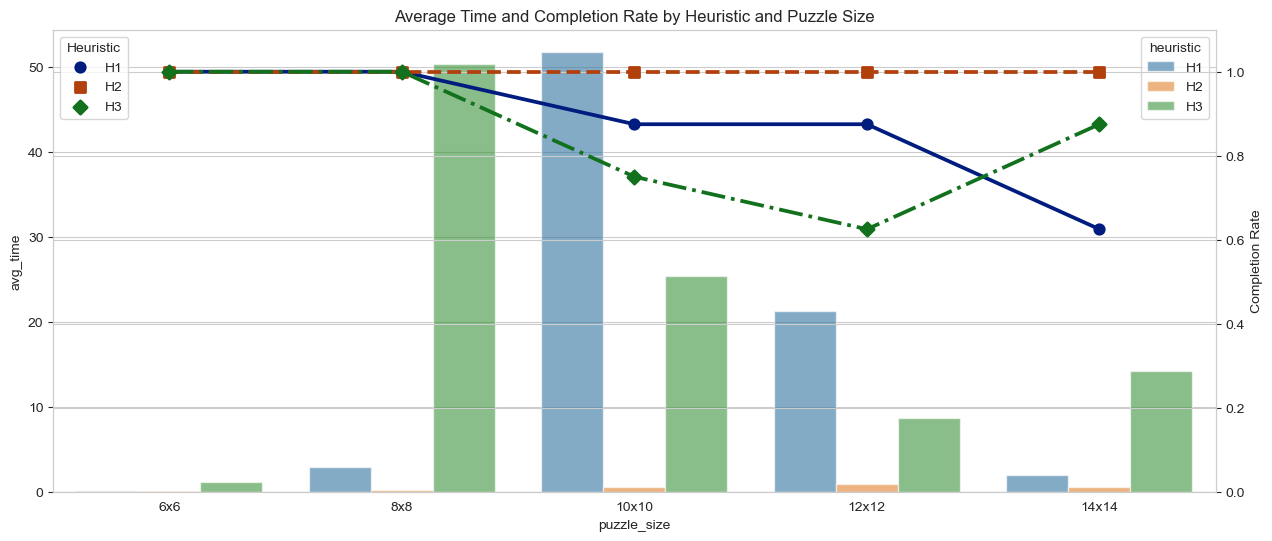

In [32]:
# Ordering the puzzle sizes
ordered_sizes = ['6x6', '8x8', '10x10', '12x12', '14x14']
grouped_by_size['puzzle_size'] = pd.Categorical(grouped_by_size['puzzle_size'], categories=ordered_sizes, ordered=True)

# Plotting avg_time with completion rate overlay for different heuristics across puzzle sizes
plt.figure(figsize=(15, 6))

# Primary axis - average time
sns.barplot(x='puzzle_size', y='avg_time', hue='heuristic', data=grouped_by_size, alpha=0.6)

# Secondary axis - completion rate
plt.twinx()
sns.pointplot(x='puzzle_size', y='is_complete', hue='heuristic', data=grouped_by_size, markers=["o", "s", "D"],
             linestyles=["-", "--", "-."], palette="dark")

# Setting labels, titles, and legends
plt.title('Average Time and Completion Rate by Heuristic and Puzzle Size')
plt.ylabel('Completion Rate')
plt.ylim(0, 1.1)
plt.legend(title='Heuristic', loc='upper left')

plt.show()

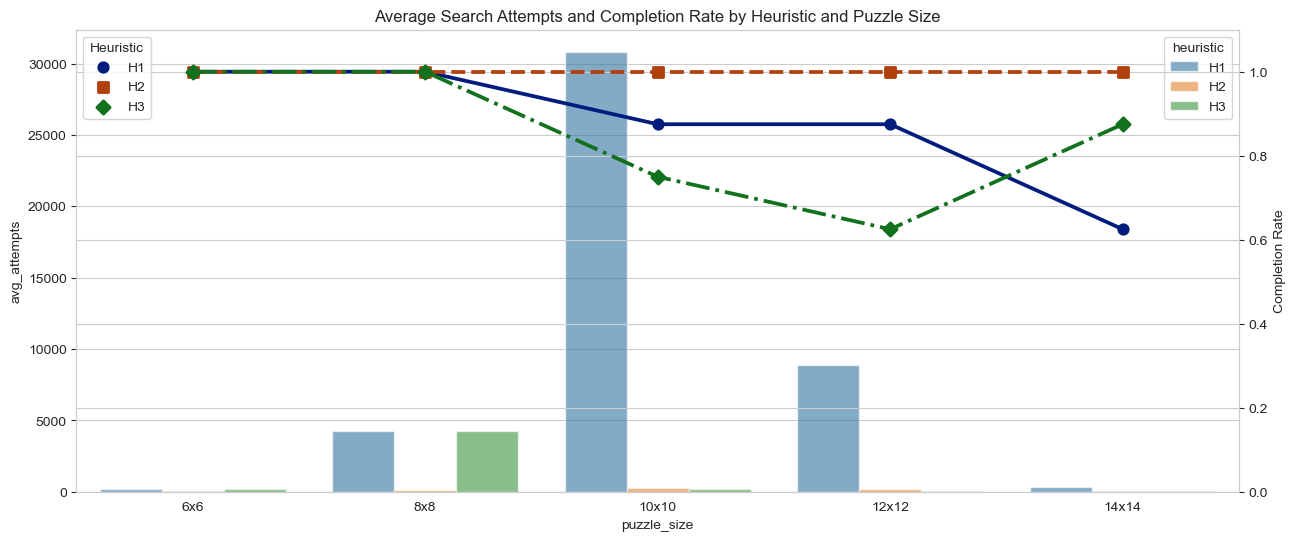

In [33]:
# Plotting avg_attempts with completion rate overlay for different heuristics across puzzle sizes
plt.figure(figsize=(15, 6))

# Primary axis - average attempts
sns.barplot(x='puzzle_size', y='avg_attempts', hue='heuristic', data=grouped_by_size, alpha=0.6)

# Secondary axis - completion rate
plt.twinx()
sns.pointplot(x='puzzle_size', y='is_complete', hue='heuristic', data=grouped_by_size, markers=["o", "s", "D"],
             linestyles=["-", "--", "-."], palette="dark")

# Setting labels, titles, and legends
plt.title('Average Search Attempts and Completion Rate by Heuristic and Puzzle Size')
plt.ylabel('Completion Rate')
plt.ylim(0, 1.1)
plt.legend(title='Heuristic', loc='upper left')

plt.show()

### Impact of Heuristics on Different Puzzle Difficulties with Completion Overlay

In [13]:
# Grouping by heuristic and difficulty to aggregate the performance metrics
grouped_by_difficulty = combinatorial_df.groupby(['heuristic', 'difficulty']).agg({
    'avg_time': 'mean',
    'avg_attempts': 'mean',
    'is_complete': 'mean'
}).reset_index()

grouped_by_difficulty

,heuristic,difficulty,avg_time,avg_attempts,is_complete
0,H1,easy,2.668019,614.500000,1.0
1,H1,hard,11.062706,7026.000000,0.8
2,H1,medium,29.828063,15581.000000,0.8
3,H1,veryhard,21.358519,14226.333333,0.9
4,H2,easy,0.691424,115.100000,1.0
5,H2,hard,0.259002,88.400000,1.0
6,H2,medium,0.142124,51.100000,1.0
7,H2,veryhard,0.639705,306.000000,1.0
8,H3,easy,25.210654,209.500000,0.8
9,H3,hard,36.836982,3444.000000,0.9


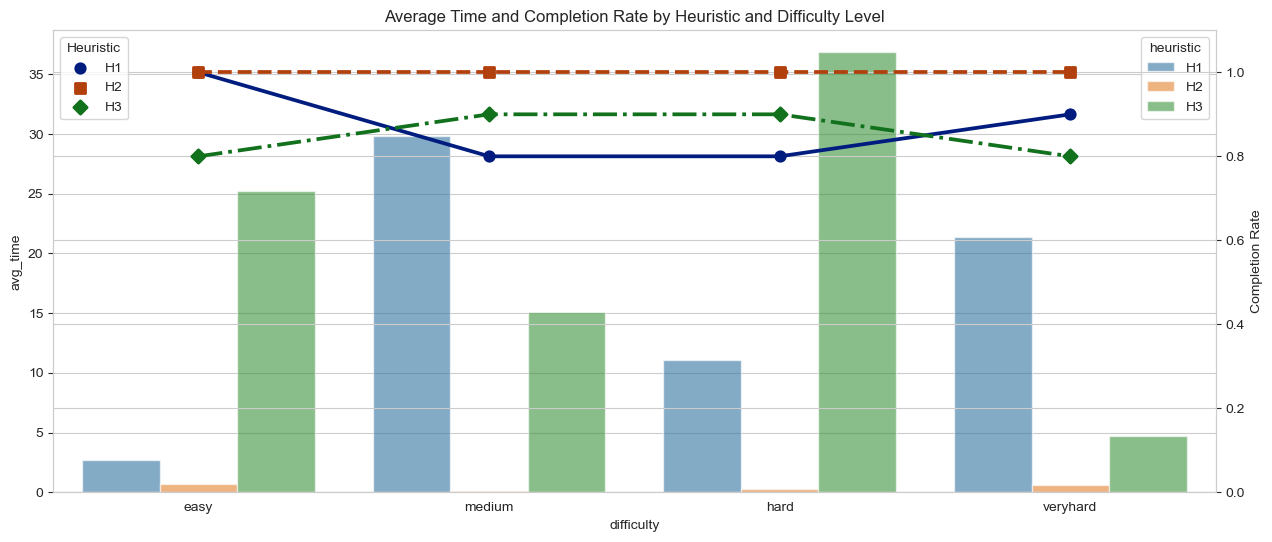

In [14]:
# Visualization Step 2: Impact of Heuristics on Different Difficulty Levels with Completion Overlay

# Ordering the difficulty levels
ordered_difficulties = ['easy', 'medium', 'hard', 'veryhard']
grouped_by_difficulty['difficulty'] = pd.Categorical(grouped_by_difficulty['difficulty'], 
                                                     categories=ordered_difficulties, ordered=True)

# Plotting avg_time with completion rate overlay for different heuristics across difficulty levels
plt.figure(figsize=(15, 6))

# Primary axis - average time
sns.barplot(x='difficulty', y='avg_time', hue='heuristic', data=grouped_by_difficulty, alpha=0.6)

# Secondary axis - completion rate
plt.twinx()
sns.pointplot(x='difficulty', y='is_complete', hue='heuristic', data=grouped_by_difficulty, markers=["o", "s", "D"],
             linestyles=["-", "--", "-."], palette="dark")

# Setting labels, titles, and legends
plt.title('Average Time and Completion Rate by Heuristic and Difficulty Level')
plt.ylabel('Completion Rate')
plt.ylim(0, 1.1)
plt.legend(title='Heuristic', loc='upper left')

plt.show()

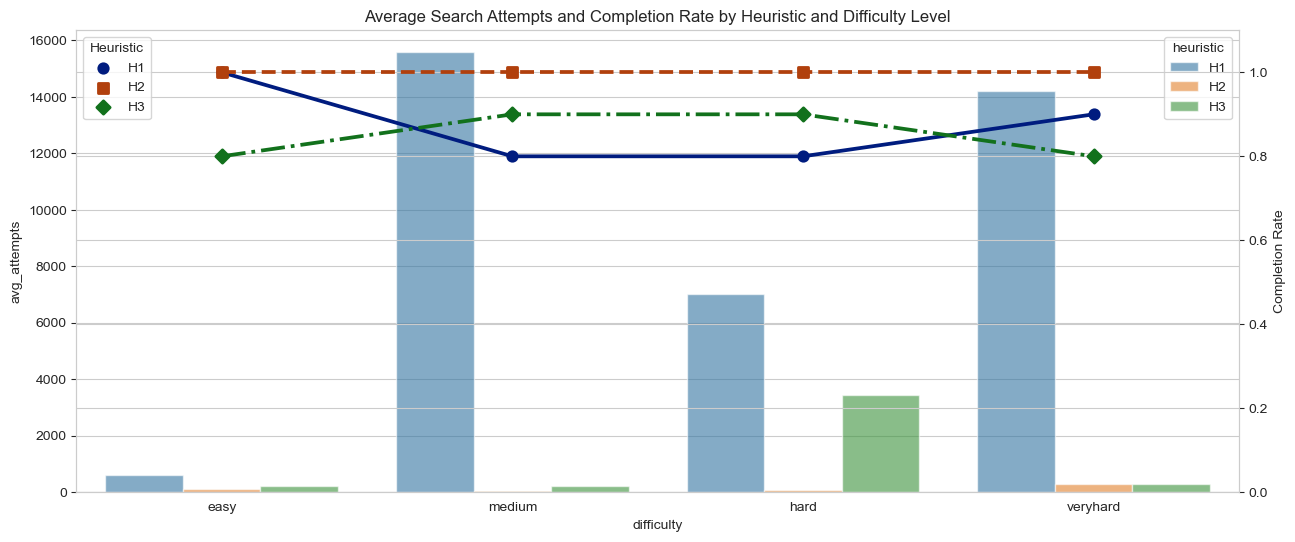

In [15]:
# Plotting avg_attempts with completion rate overlay for different heuristics across difficulty levels
plt.figure(figsize=(15, 6))

# Primary axis - average attempts
sns.barplot(x='difficulty', y='avg_attempts', hue='heuristic', data=grouped_by_difficulty, alpha=0.6)

# Secondary axis - completion rate
plt.twinx()
sns.pointplot(x='difficulty', y='is_complete', hue='heuristic', data=grouped_by_difficulty, markers=["o", "s", "D"],
             linestyles=["-", "--", "-."], palette="dark")

# Setting labels, titles, and legends
plt.title('Average Search Attempts and Completion Rate by Heuristic and Difficulty Level')
plt.ylabel('Completion Rate')
plt.ylim(0, 1.1)
plt.legend(title='Heuristic', loc='upper left')

plt.show()

### Impact of AC3 Usage on Different Puzzle Sizes with Completion Overlay

In [41]:
# Grouping by AC3 usage and puzzle size to aggregate the performance metrics without considering heuristics
grouped_by_size_ac3 = combinatorial_df.groupby(['AC3_usage', 'puzzle_size']).agg({
    'avg_time': 'mean',
    'avg_attempts': 'mean',
    'is_complete': 'mean'
}).reset_index()

grouped_by_size_ac3

,AC3_usage,puzzle_size,avg_time,avg_attempts,is_complete
0,with_ac3,10x10,44.107786,5892.777778,0.750000
1,with_ac3,12x12,19.575666,1485.000000,0.666667
2,with_ac3,14x14,4.561190,66.750000,0.666667
3,with_ac3,6x6,0.411334,71.083333,1.000000
4,with_ac3,8x8,17.630318,1352.750000,1.000000
5,without_ac3,10x10,10.207776,13847.833333,1.000000
6,without_ac3,12x12,3.604523,4351.000000,1.000000
7,without_ac3,14x14,6.435055,161.833333,1.000000
8,without_ac3,6x6,0.400311,178.666667,1.000000
9,without_ac3,8x8,18.003668,4406.833333,1.000000


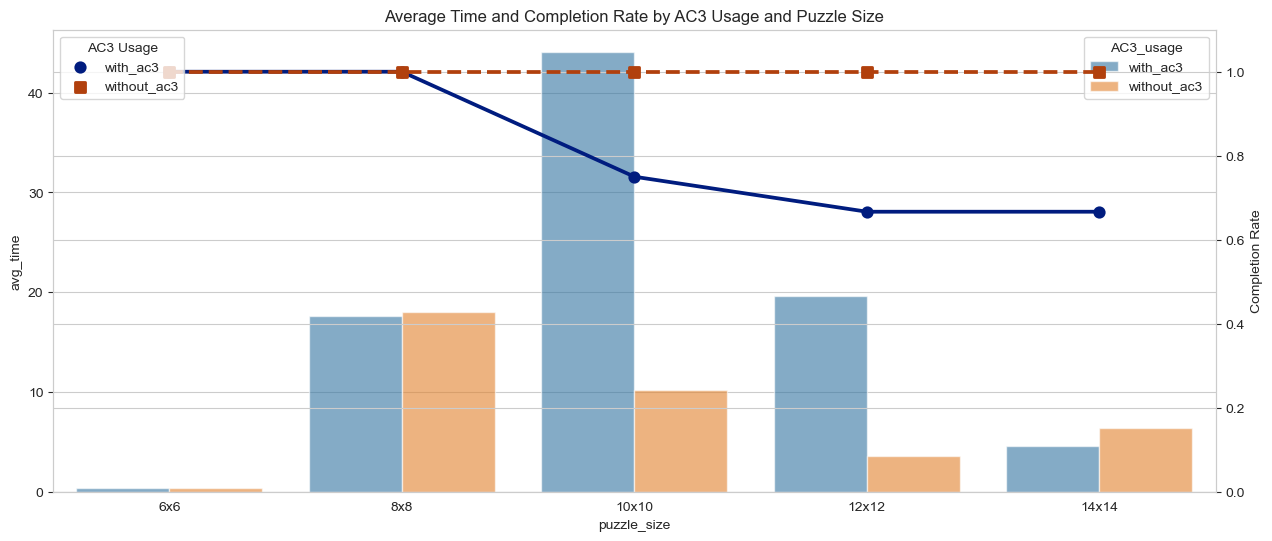

In [45]:
# Ordering the puzzle sizes for the grouped data without considering heuristics
grouped_by_size_ac3['puzzle_size'] = pd.Categorical(grouped_by_size_ac3['puzzle_size'], 
                                                                categories=ordered_sizes, ordered=True)

# Plotting avg_time with completion rate overlay for AC3 usage and puzzle sizes (corrected order)
plt.figure(figsize=(15, 6))

# Primary axis - average time
sns.barplot(x='puzzle_size', y='avg_time', hue='AC3_usage', data=grouped_by_size_ac3, alpha=0.6)

# Secondary axis - completion rate
plt.twinx()
sns.pointplot(x='puzzle_size', y='is_complete', hue='AC3_usage', data=grouped_by_size_ac3,
             markers=["o", "s"], linestyles=["-", "--"], palette="dark")

# Setting labels, titles, and legends
plt.title('Average Time and Completion Rate by AC3 Usage and Puzzle Size')
plt.ylabel('Completion Rate')
plt.ylim(0, 1.1)
plt.legend(title='AC3 Usage', loc='upper left')

plt.show()

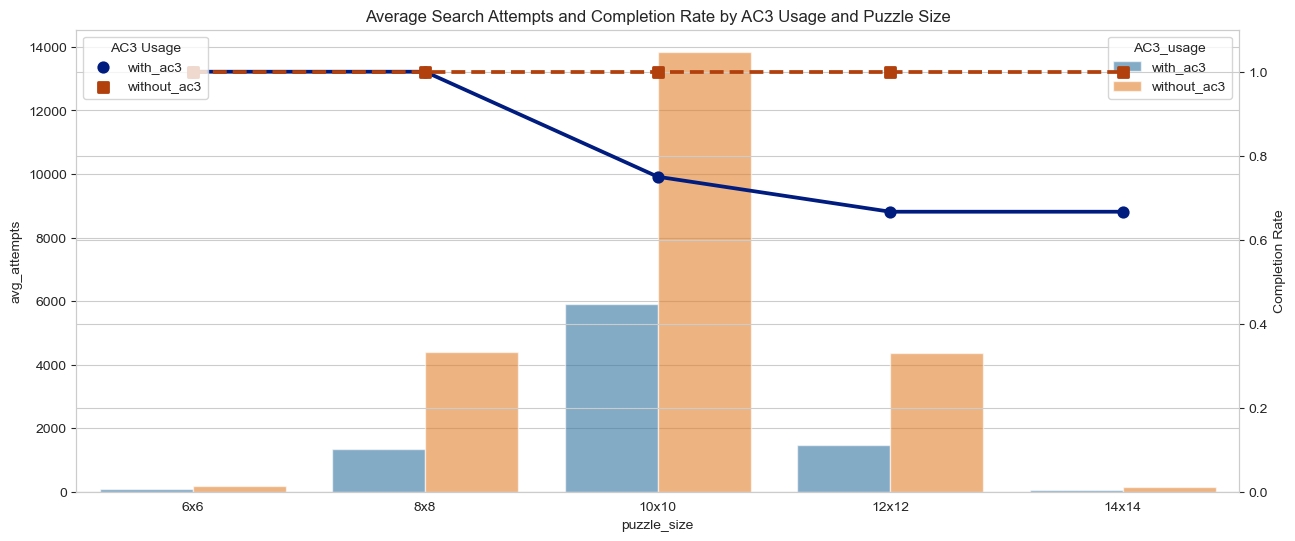

In [43]:
# Plotting avg_attempts with completion rate overlay for AC3 usage and puzzle sizes
plt.figure(figsize=(15, 6))

# Primary axis - average attempts
sns.barplot(x='puzzle_size', y='avg_attempts', hue='AC3_usage', data=grouped_by_size_ac3, alpha=0.6)

# Secondary axis - completion rate
plt.twinx()
sns.pointplot(x='puzzle_size', y='is_complete', hue='AC3_usage', data=grouped_by_size_ac3,
             markers=["o", "s"], linestyles=["-", "--"], palette="dark")

# Setting labels, titles, and legends
plt.title('Average Search Attempts and Completion Rate by AC3 Usage and Puzzle Size')
plt.ylabel('Completion Rate')
plt.ylim(0, 1.1)
plt.legend(title='AC3 Usage', loc='upper left')

plt.show()

### Impact of AC3 Usage on Different Puzzle Difficulties with Completion Overlay

In [17]:
# Grouping by AC3 usage and difficulty to aggregate the performance metrics without considering heuristics
grouped_by_difficulty_ac3 = combinatorial_df.groupby(['AC3_usage', 'difficulty']).agg({
    'avg_time': 'mean',
    'avg_attempts': 'mean',
    'is_complete': 'mean'
}).reset_index()

grouped_by_difficulty_ac3

,AC3_usage,difficulty,avg_time,avg_attempts,is_complete
0,with_ac3,easy,5.661409,159.538462,0.866667
1,with_ac3,hard,20.008167,1631.500000,0.800000
2,with_ac3,medium,23.306431,2801.166667,0.800000
3,with_ac3,veryhard,17.765938,2272.416667,0.800000
4,without_ac3,easy,10.778756,459.866667,1.000000
5,without_ac3,hard,12.168434,4567.333333,1.000000
6,without_ac3,medium,6.440274,6247.466667,1.000000
7,without_ac3,veryhard,1.533603,7082.266667,1.000000


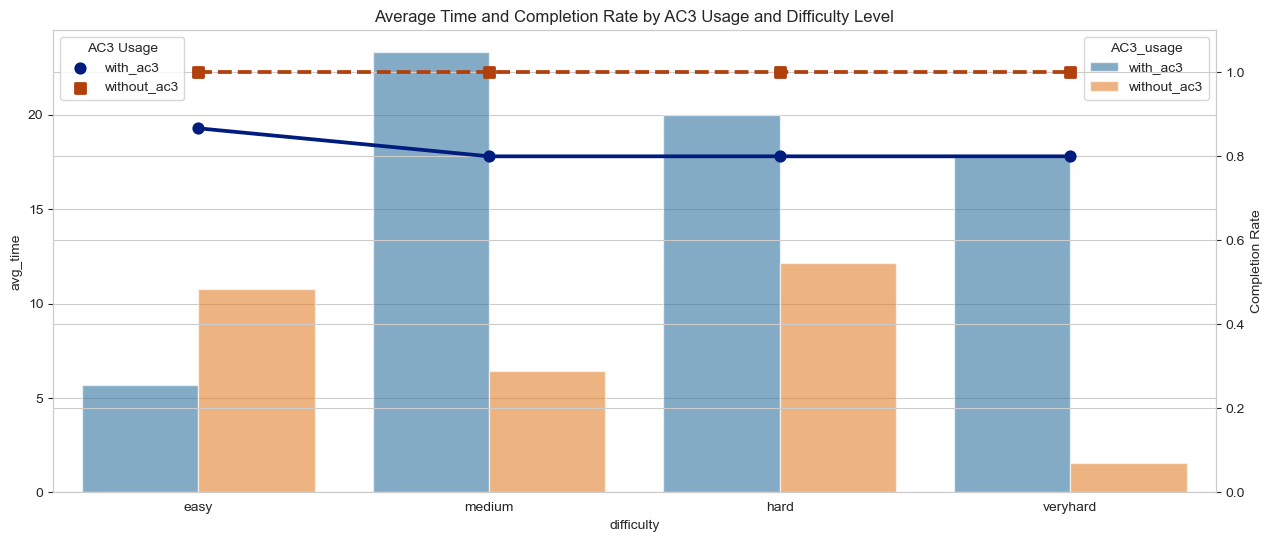

In [18]:
# Ordering the difficulty levels for the grouped data
grouped_by_difficulty_ac3['difficulty'] = pd.Categorical(grouped_by_difficulty_ac3['difficulty'], 
                                                                     categories=ordered_difficulties, ordered=True)

# Plotting avg_time with completion rate overlay for AC3 usage and difficulty levels
plt.figure(figsize=(15, 6))

# Primary axis - average time
sns.barplot(x='difficulty', y='avg_time', hue='AC3_usage', data=grouped_by_difficulty_ac3, alpha=0.6)

# Secondary axis - completion rate
plt.twinx()
sns.pointplot(x='difficulty', y='is_complete', hue='AC3_usage', data=grouped_by_difficulty_ac3,
             markers=["o", "s"], linestyles=["-", "--"], palette="dark")

# Setting labels, titles, and legends
plt.title('Average Time and Completion Rate by AC3 Usage and Difficulty Level')
plt.ylabel('Completion Rate')
plt.ylim(0, 1.1)
plt.legend(title='AC3 Usage', loc='upper left')

plt.show()

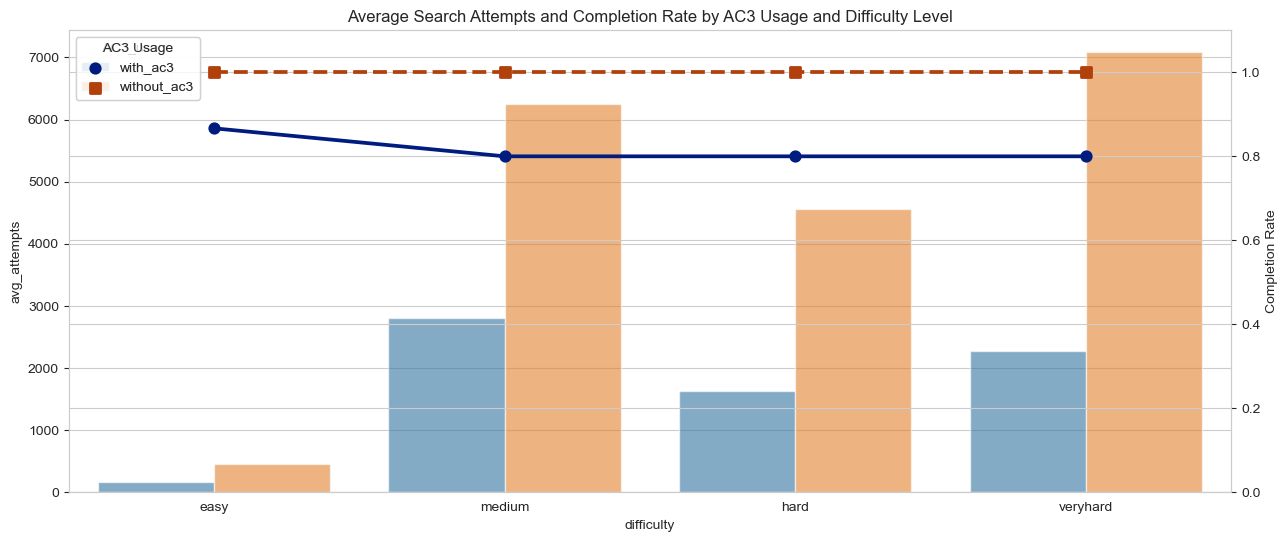

In [19]:
# Plotting avg_attempts with completion rate overlay for AC3 usage and difficulty levels
plt.figure(figsize=(15, 6))

# Primary axis - average attempts
sns.barplot(x='difficulty', y='avg_attempts', hue='AC3_usage', data=grouped_by_difficulty_ac3, alpha=0.6)

# Secondary axis - completion rate
plt.twinx()
sns.pointplot(x='difficulty', y='is_complete', hue='AC3_usage', data=grouped_by_difficulty_ac3,
             markers=["o", "s"], linestyles=["-", "--"], palette="dark")

# Setting labels, titles, and legends
plt.title('Average Search Attempts and Completion Rate by AC3 Usage and Difficulty Level')
plt.ylabel('Completion Rate')
plt.ylim(0, 1.1)
plt.legend(title='AC3 Usage', loc='upper left')

plt.show()